# 生成检测器

In [2]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

In [3]:
detector = cv.CascadeClassifier("D:/ProgramData/Anaconda3/Lib/site-packages/cv2/data/haarcascade_frontalface_alt2.xml")

# 使用opencv处理人脸图片

In [70]:
rawimgpath = "C:/Users/lenovo/Documents/tfstudy/pic/me/"
rawimgpath2 = "C:/Users/lenovo/Documents/tfstudy/pic/notme/"
imgpath = "C:/Users/lenovo/Documents/tfstudy/pic/face_me/"
imgpath2 = "C:/Users/lenovo/Documents/tfstudy/pic/face_not_me/"

height = 100
width = 100

In [78]:
#将image统一补全并缩放成相同的大小
def resize_with_pad(image, height, width):
 
    #计算后续填充图片时的上、下、左、右的像素点
    def get_padding_size(image):
        h, w = image.shape
        longest_edge = max(h, w)
        top, bottom, left, right = (0, 0, 0, 0)
        if h < longest_edge:
            dh = longest_edge - h
            top = dh // 2
            bottom = dh - top
        elif w < longest_edge:
            dw = longest_edge - w
            left = dw // 2
            right = dw - left
        else:
            pass
        return top, bottom, left, right
 
    top, bottom, left, right = get_padding_size(image)
    BLACK = [0, 0, 0]
    #填充图片
    constant = cv.copyMakeBorder(image, top , bottom, left, right, cv.BORDER_CONSTANT, value=BLACK)
    #缩放图片以统一输入
    resized_image = cv.resize(constant, (height, width))
    return resized_image

In [76]:
#读取图片并储存
def generate_faces_img(rawimgpath,num, imgpath):
    path = rawimgpath + str(num) + ".jpg"
    img = cv.imread(path)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    gray = cv.equalizeHist(gray) #直方图均衡化
    faces = detector.detectMultiScale(gray, 1.1, 9)
    for (x, y, w, h) in faces:
        savepath = imgpath + str(num) + ".jpg"
        face_gray = gray[y:y+h,x:x+w]
        face_resize = resize_with_pad(face_gray, height, width)
        cv.imwrite(savepath, face_resize)

In [80]:
picindex = 1
picnum = 113

while True:
    generate_faces_img(rawimgpath, picindex, imgpath)
    picindex += 1
    if picindex > picnum:
        break
    

In [81]:
picindex = 1
picnum = 191

while True:
    generate_faces_img(rawimgpath2, picindex, imgpath2)
    picindex += 1
    if picindex > picnum:
        break
  

# CNN实现人脸解锁

In [4]:
import tf_record_utils as util
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split

In [5]:
#打开图片数据
filedir = "C:\\Users\\lenovo\\Documents\\tfstudy\\pic"
categorys = ["face_me","face_not_me"]
imagearrays,imagelabels,_ = util.grey_image_arrays(categorys, filedir)
imagearrays.shape

(214, 100, 100, 1)

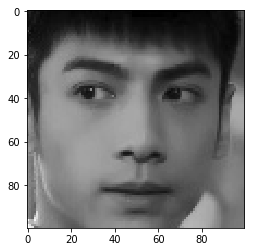

In [6]:
#查看其中一张图片
plt.imshow(np.reshape(imagearrays[120],(100,100)), cmap ='gray')

In [7]:
#查看对应类型
imagelabels[120]

2

In [8]:
imagelabels = pd.get_dummies(imagelabels)
imagelabels.columns = ["me", "notme"]
imagelabels.head(5)

,me,notme
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [9]:
#拆分训练集和测试集
data,testdata,labels,testlabels = train_test_split(imagearrays, imagelabels,test_size=0.2)

In [10]:
#设置超参数
learning_rate = 0.001
epochs = 10000  #一共运行几大轮
batch_size = 10 #随机梯度下降，一小轮含多少张图片

#神经网络参数
n_classess = 2 #只有两类，我和非我
drop_out = 0.5
weights = {
    #卷积层1 ： 7 * 7 数量32个 步长2
    "wc1" : tf.Variable(tf.truncated_normal([7, 7, 1, 32], dtype=tf.float32)),
    #卷积层2 ： 5 * 5 数量64个 步长1
    "wc2" : tf.Variable(tf.truncated_normal([5, 5, 32, 64], dtype=tf.float32)),
    #卷积层3： 3 * 3 数量128个 步长1
    "wc3" : tf.Variable(tf.truncated_normal([3, 3, 64, 128], dtype=tf.float32)),
    #全连接层1： 含1024个隐藏神经元
    "wd1" : tf.Variable(tf.truncated_normal([7 * 7 * 128, 1024], dtype=tf.float32)),
    #全连接层2:  含1024个隐藏神经元
    "wd2" : tf.Variable(tf.truncated_normal([1024, 1024], dtype=tf.float32)),
    #softmax全连接层： 含两个out神经元
    "out" : tf.Variable(tf.truncated_normal([1024, n_classess], dtype=tf.float32))
}

biases = {
    "bc1" : tf.Variable(tf.zeros([32], dtype=tf.float32)),
    "bc2" : tf.Variable(tf.zeros([64], dtype=tf.float32)),
    "bc3" : tf.Variable(tf.zeros([128], dtype=tf.float32)),
    "bd1" : tf.Variable(tf.zeros([1024], dtype=tf.float32)),
    "bd2" : tf.Variable(tf.zeros([1024], dtype=tf.float32)),
    "out" : tf.Variable(tf.zeros([n_classess], dtype=tf.float32))
}

In [11]:
def con2d(x, w , b, strides = 1, mode = "SAME"):
    x = tf.nn.conv2d(input=x, filter=w, 
                    strides = [1, strides, strides, 1], padding = mode)
    return tf.nn.relu(x)

In [12]:
def maxpool2d(x, k = 2, mode = "SAME"):
    x = tf.nn.max_pool(x, strides=[1, k, k, 1],
                      ksize = [1, k, k, 1], padding = mode)
    return x

In [13]:
def conv_net(x, weights, biases, dropout = 1):
    #卷积层1 100 * 100 to 50 * 50
    conv1 = con2d(x, weights["wc1"], biases["bc1"], strides=2)
    #池化 50 * 50  to 25 * 25
    conv1 = maxpool2d(conv1, k = 2)
    
    #卷积层2 25 * 25 to 25 * 25
    conv2 = con2d(conv1, weights["wc2"], biases["bc2"], strides=1)
    #池化 25 * 25 to 13 * 13
    conv2 = maxpool2d(conv2, k = 2)
    
    #卷积层3 13 * 13 to 13 * 13
    conv3 = con2d(conv2, weights["wc3"], biases["bc3"], strides=1)
    #池化 13 * 13 to 7 * 7
    conv5 = maxpool2d(conv3, k = 2)
    
    #全连接层1 7 * 7* 128 to 1024
    fc1 = tf.reshape(conv5, shape = [-1, weights["wd1"].get_shape().as_list()[0]])
    fc1 = tf.matmul(fc1, weights["wd1"])
    fc1 = tf.add(fc1, biases["bd1"])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob=dropout)
    print(fc1)
    
    #全连接层2 1024 to 1024
    fc2 = tf.matmul(fc1, weights["wd2"])
    fc2 = tf.add(fc2, biases["bd2"])
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc1, keep_prob=dropout)
    print(fc2)
    
    #输出层 1024 to 2
    out = tf.matmul(fc2, weights["out"])
    out = tf.add(out, biases["out"])
    return out

In [14]:
#tf placeholder 输入
x = tf.placeholder(tf.float32, [None, 100, 100, 1])
y = tf.placeholder(tf.float32, [None, n_classess])

keep_prob = tf.placeholder(tf.float32)

In [15]:
#损失与梯度下降
logits = conv_net(x, weights, biases, keep_prob)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

#准确率
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

Tensor("dropout/mul:0", shape=(?, 1024), dtype=float32)
Tensor("dropout_1/mul:0", shape=(?, 1024), dtype=float32)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [16]:
#准备训练数据
def next_batch(batchsize, x, y):
    n_batches = x.shape[0] // batchsize
    x = x[:n_batches * batch_size, :, : , :]
    y = y.iloc[:n_batches * batchsize, :]
    
    for n in range(0, len(y), batchsize):
        batch_x = x[n : n + batchsize, :, :, :]
        batch_y = y.iloc[n : n + batchsize, :]
        yield batch_x, batch_y

In [18]:
#启动会话，开始训练
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print("训练开始！")
    
    for epoch in range(epochs):
        epoch += 1
        accur = 0
        loss = 0
        for batch_x, batch_y in next_batch(batch_size, data, labels):
            feed = {
                x : batch_x,
                y : batch_y,
                keep_prob : drop_out
            }
            
            feed_valid = {
                x : batch_x,
                y : batch_y,
                keep_prob : 1
            }
            
            sess.run(optimizer, feed_dict=feed)
            #vaild_loss = sess.run(loss,feed_dict=feed_valid)
            valid_accur = sess.run(accuracy, feed_dict=feed_valid)
            accur += valid_accur
            #epoch_loss += vaild_loss
            
        print("第",epoch, "轮，准确率为：", accur/(data.shape[0]// batch_size))
        if epoch % 5 == 0:
            #测试集准确率
            test_acc = sess.run(accuracy, feed_dict={
                x: testdata,
                y: testlabels,
                keep_prob :1.})
            print('Testing Accuracy: {}'.format(test_acc)) 
            if test_acc > 0.95:
                print("训练结束！")
                break

训练开始！
第 1 轮，准确率为： 0.7176470546161428
第 2 轮，准确率为： 0.7705882402027354
第 3 轮，准确率为： 0.86470588165171
第 4 轮，准确率为： 0.7999999943901511
第 5 轮，准确率为： 0.8941176393452812
Testing Accuracy: 0.8139534592628479
第 6 轮，准确率为： 0.8823529306580039
第 7 轮，准确率为： 0.8823529271518483
第 8 轮，准确率为： 0.9235293970388525
第 9 轮，准确率为： 0.8999999936889199
第 10 轮，准确率为： 0.9411764600697685
Testing Accuracy: 0.8604651093482971
第 11 轮，准确率为： 0.9411764635759241
第 12 轮，准确率为： 0.958823519594529
第 13 轮，准确率为： 0.9235294040511636
第 14 轮，准确率为： 0.9647058739381678
第 15 轮，准确率为： 0.9647058774443233
Testing Accuracy: 0.9069767594337463
第 16 轮，准确率为： 0.9705882282818065
第 17 轮，准确率为： 0.9764705826254452
第 18 轮，准确率为： 0.9588235231006846
第 19 轮，准确率为： 0.9823529369690839
第 20 轮，准确率为： 0.9941176456563613
Testing Accuracy: 0.8837209343910217
第 21 轮，准确率为： 0.9764705826254452
第 22 轮，准确率为： 1.0
第 23 轮，准确率为： 0.9882352913127226
第 24 轮，准确率为： 0.9823529369690839
第 25 轮，准确率为： 0.970588231787962
Testing Accuracy: 0.9069767594337463
第 26 轮，准确率为： 0.9941176456563613
第 27 